# Sample Similarity

The goal of a Resemblance Model is understanding how different two samples are from a multivariate perspective. For instance, if you suspect that your Out-Of-Time test set may have a different distribution than the In-Time train set, you can detect that using the Resemblance Model.

<img src="resemblance.png" width="700">


Having two datasets `X1` and `X2` with the same features, one can analyse how easy is it to recognize which dataset a randomly selected row comes from. The Resemblance model assigns label `0` to `X1` dataset, and label `1` to `X2`, and trains a binary classification model to predict, which sample a given row comes from. 

If this model has an AUC over 0.5 on data held out from training, it indicates that the distributions are different, because the model can distinguish between them. The higher the AUC, the larger the difference between two datasets. Finally, feature importance indicates, which features are the most predictive, and therefore, differ the most for the two datasets.

## Setup

In [1]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# Prepare two samples
feature_names = ['f1', 'f2', 'f3', 'f4']
X1 = pd.DataFrame(make_classification(n_samples=1000, n_features=4)[0], columns=feature_names)
X2 = pd.DataFrame(make_classification(n_samples=1000, n_features=4, shift=0.5)[0], columns=feature_names)

# Prepare model
clf = RandomForestClassifier(n_estimators = 100, max_depth=2, random_state=0)

There are two classes in probatus that allow you to analyse, how the distribution of the features in the two samples differ:

**SHAPImportanceResemblance (Recommended)** - Trains a Resemblance model based on **tree classifier**, then it uses SHAP library to analyse the differences in features between the two samples. Currently, it uses shap.TreeExplainer to interpret the model. The main advantage of using this method is its high speed, better understanding of the relations in the data and handling of categorical features and missing values.

**PermutationImportanceResemblance** - Trains a Resemblance model for **any provided classifier**, and uses Permutation Importance to analyse, which features the model relies on. It is significantly slower, and requires preprocessing of the data before training the resemblance model.

## SHAP Importance Resemblance Model for Tree models

Below you can see an example of how to use the model:

In [2]:
from probatus.sample_similarity import SHAPImportanceResemblance

rm = SHAPImportanceResemblance(clf)
feature_importance, train_auc, test_auc = rm.fit_compute(X1, X2, columns=feature_names, return_auc=True)

print(f'Train AUC {train_auc}, Test AUC {test_auc}')
display(feature_importance)

Train AUC 0.9342324931416249, Test AUC 0.9307216858016685


,column_name,shap_importance
3,f4,0.110546
1,f2,0.085101
0,f1,0.037294
2,f3,0.022373


By looking into the above results, one can conclude that the two samples significantly differ, since the Test AUC of the model is very high.

The table shows, which features have the highest importance, while making the prediction. We can automatically plot the results using the below function.

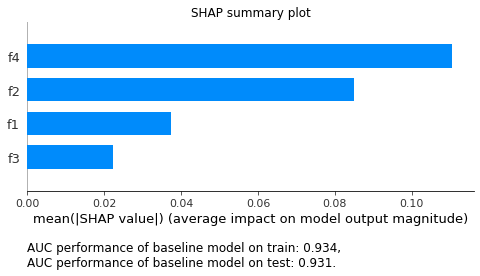

In [3]:
ax = rm.plot()

In order to get more insights of the change in underlying relations in the data, let's plot a dot summary plot.

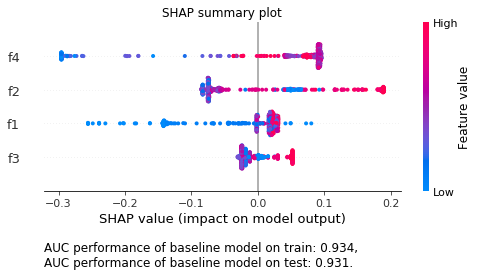

In [4]:
ax = rm.plot(plot_type='dot')

We can see that second sample have higher values in all the features.

## Permutation Importance Resemblance Model

Below we show the example on how to use the PermutationImportanceResemblance

In [5]:
from probatus.sample_similarity import PermutationImportanceResemblance
perm = PermutationImportanceResemblance(clf)

feature_importance, train_auc, test_auc = perm.fit_compute(X1, X2, columns=feature_names, return_auc=True)
print(f'Train AUC {train_auc}, Test AUC {test_auc}')
display(feature_importance)

Train AUC 0.9342324931416249, Test AUC 0.9307216858016685


,mean_importance,std_importance
f4,0.164878,0.015667
f1,0.127722,0.011479
f2,0.114157,0.014356
f3,0.025083,0.005830


Same as before, we can get more insights into the importance of the features. However, now we can also analyse standard deviation of the permutation importance. High std might indicate that permutation of this feature has a higher or lower impact only in part of the available samples, while low std, indicates a consistent effect.

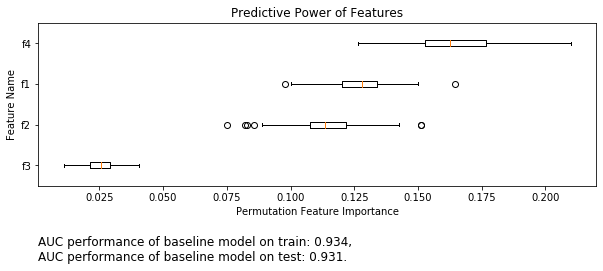

In [6]:
perm.plot()

## Visualize the difference in the most important feature

We can also use the utils to provide more insights into the feature distribution difference in the two samples.

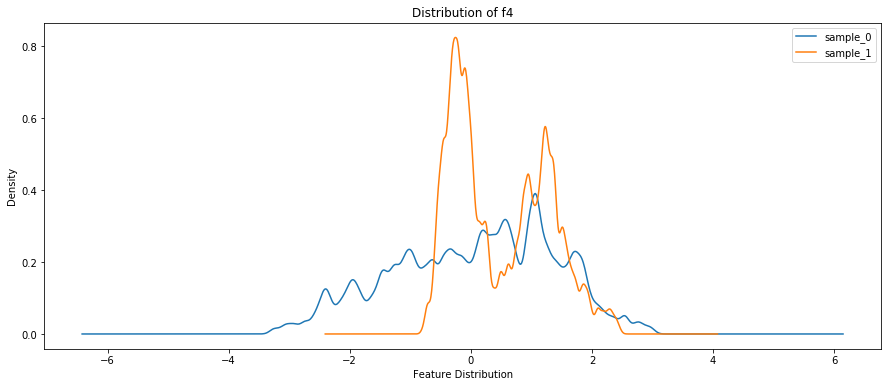

In [8]:
from probatus.utils.plots import plot_distributions_of_feature

feature_distributions = [X1['f4'], X2['f4']]
plot_distributions_of_feature(feature_distributions, plot_perc_outliers_removed=0.01)